# Denoising Diffusion Probabilistic Models with MedNIST Dataset Bundle 

This notebook discusses and uses the MONAI bundle it's included in for generating images from the MedNIST dataset using diffusion models. This is based off the 2d_ddpm_tutorial_ignite.ipynb notebook with a few changes.

The bundle defines training and inference scripts whose use will be described here along with visualisations. The assumption with this notebook is that it's run within the bundle's `docs` directory and that the environment it runs in has `MONAI` installed. The command lines given are known to work in `bash` however may be problematic in Windows.

Specifically, we train a diffusion model to generate X-Ray hands (drawn from the MedNIST dataset).

First thing to do is import libraries and verify MONAI is present:

In [1]:
import os
import shutil
import tempfile
from pathlib import Path

import torch

import matplotlib.pyplot as plt
import monai
from monai.bundle import ConfigParser

# path to the bundle directory, this assumes you're running the notebook in its directory
bundle_root = str(Path(".").absolute().parent)

monai.config.print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /media/<username>/BigCrumb/POSTDOC_FEDERATED_LEARNING/PRODIGY_PROJECT/monai-model-zoo/venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 11.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 5.2.0
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.1
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.0
transformers version: 4.46.3
mlflow version: NOT INSTALLED or UNKNOWN V

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
dataset_dir = tempfile.mkdtemp() if directory is None else directory
print(dataset_dir)

/tmp/tmpwv12iwwo


### Training the diffusion model

A bundle can be run on the command line using the Fire library or by parsing the configuration manually then getting parsed content objects. The following is the command to train the network for the default number of epochs. It will define values in the config files which need to be set for a particular run, such as the dataset directory created above, and setting the PYTHONPATH variable. The configuration for this bundle is split into 4 yaml files, one having common definitions for training and inference (common.yaml), one to enable multi-GPU training (train_multigpu.yaml), and one each for training (train.yaml) and inference (inference.yaml). Their combinations determine what your final configuration is, in this case the common and train files produce a training script. 

The dataset information is available in configs/common.yaml. The transformations to which the data is subject, which is basically the addition of a channel dimension and the scaling of the images between 0 and 1, is in each task yaml file. 

In [3]:
# multiple config files need to be specified this way with '' quotes, variable used in command line must be in "" quotes
configs=f"'{bundle_root}/configs/common.yaml', '{bundle_root}/configs/train.yaml'"
output_dir = "outputs"
!PYTHONPATH={bundle_root} python -m monai.bundle run training \
    --meta_file {bundle_root}/configs/metadata.json \
    --config_file "{configs}" \
    --logging_file {bundle_root}/configs/logging.conf \
    --bundle_root {bundle_root} \
    --dataset_dir {dataset_dir} \
    --output_dir {output_dir}

2025-01-12 15:03:16,093 - INFO - --- input summary of monai.bundle.scripts.run ---
2025-01-12 15:03:16,093 - INFO - > config_file: ('./configs/common.yaml',
 './configs/train.yaml')
2025-01-12 15:03:16,093 - INFO - > meta_file: './configs/metadata.json'
2025-01-12 15:03:16,093 - INFO - > logging_file: '/monai-model-zoo/model-zoo/models/mednist_ddpm/configs/logging.conf'
2025-01-12 15:03:16,093 - INFO - > run_id: 'training'
2025-01-12 15:03:16,093 - INFO - > bundle_root: '/model-zoo/models/mednist_ddpm'
2025-01-12 15:03:16,093 - INFO - > dataset_dir: '/tmp/tmpwv12iwwo'
2025-01-12 15:03:16,093 - INFO - ---


2025-01-12 15:03:16,093 - INFO - Setting logging properties based on config: ./configs/logging.conf.
2025-01-12 15:03:17,424 - INFO - Downloaded: /tmp/tmpwv12iwwo/MedNIST.tar.gz
2025-01-12 15:03:17,500 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-01-12 15:03:17,500 - INFO - Writing into directory: /tmp/tmpwv12iwwo.
2025-01-12 15:03:38,425 - INFO - V

### Test the diffusion model

The test inference script can then be invoked as such to produce an output tensor saved to the given file with a randomly generated image. The `ckpt_path` value should point to the final checkpoint file created during the above training run, which will be in a subdirectory of `./results`. The training script's default behaviour is to create a new timestamped subdirectory in `./results` for every new run, this can be explicitly set by providing a `output_dir` value on the command line.

2025-01-12 19:11:01,720 - INFO - --- input summary of monai.bundle.scripts.run ---
2025-01-12 19:11:01,721 - INFO - > config_file: ('./common.yaml',
 './configs/infer.yaml')
2025-01-12 19:11:01,721 - INFO - > meta_file: './configs/metadata.json'
2025-01-12 19:11:01,721 - INFO - > run_id: 'testing'
2025-01-12 19:11:01,721 - INFO - > ckpt_path: './results/output_250112_150340/model_final_iteration=75000.pt'
2025-01-12 19:11:01,721 - INFO - > bundle_root: '/model-zoo/models/mednist_ddpm'
2025-01-12 19:11:01,721 - INFO - > out_file: 'test.pt'
2025-01-12 19:11:01,721 - INFO - ---


2025-01-12 19:11:01,721 - INFO - Setting logging properties based on config: ./configs/logging.conf.
<string>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECUR

/tmp/ipykernel_2473027/522477091.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load("test.pt", map_location="cpu")


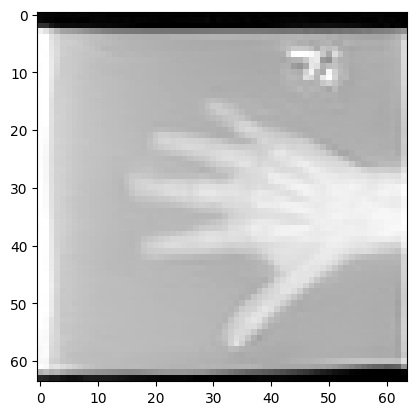

In [13]:
configs=f"'{bundle_root}/configs/common.yaml', '{bundle_root}/configs/infer.yaml'"

!PYTHONPATH={bundle_root} python -m monai.bundle run testing \
    --meta_file {bundle_root}/configs/metadata.json \
    --config_file "{configs}" \
    --ckpt_path ./results/{output_dir}/model_final_iteration=75000.pt \
    --bundle_root {bundle_root} \
    --out_file test.pt

test = torch.load("test.pt", map_location="cpu")

plt.imshow(test[0, 0], vmin=0, vmax=1, cmap="gray")

The same can be done by creating the parser object, filling in its configuration, then resolving the Python objects from the constructed bundle data:

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.56it/s]


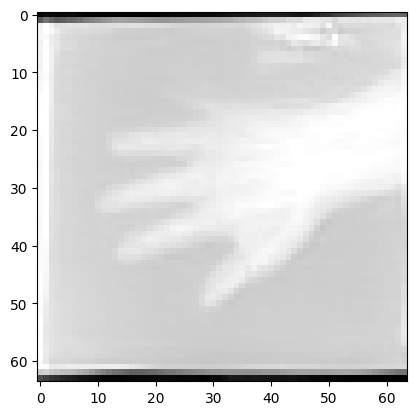

In [15]:
import sys

sys.path.append(bundle_root)  # make sure we load the script files we need

# configure the parser from the bundle's information
cp = ConfigParser()
cp.read_meta(f"{bundle_root}/configs/metadata.json")
cp.read_config([f"{bundle_root}/configs/common.yaml", f"{bundle_root}/configs/infer.yaml"])
cp["bundle_root"] = bundle_root
cp["ckpt_path"] = f"./results/{output_dir}/model_final_iteration=75000.pt"

cp.get_parsed_content("load_state")  # load the saved state from the checkpoint just be resolving this value

device = cp.get_parsed_content("device")  # device used by the bundle
sample = cp.get_parsed_content("sample")  # test sampling function

image_dim = cp["image_dim"]  # get the stored dimension value, no need to resolve anything

noise = torch.rand(1, 1, image_dim, image_dim).to(device)  # or cp.get_parsed_content("noise")

test = sample(noise)

plt.imshow(test[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")

Multi-GPU can be enabled by including the `train_multigpu.yaml` configuration file:

In [ ]:
configs=f"'{bundle_root}/configs/common.yaml', '{bundle_root}/configs/train.yaml', '{bundle_root}/configs/train_multigpu.yaml'"

!PYTHONPATH={bundle_root} torchrun --standalone --nnodes=1 --nproc_per_node=2 -m monai.bundle run training \
    --meta_file {bundle_root}/configs/metadata.json \
    --config_file "{configs}" \
    --logging_file {bundle_root}/configs/logging.conf \
    --bundle_root {bundle_root} \
    --dataset_dir {dataset_dir} \
    --output_dir {output_dir} 

In [ ]:
if directory is None:
    shutil.rmtree(dataset_dir)